In [1]:
%tensorflow_version 2

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


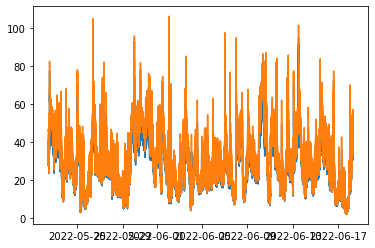

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import csv
import pandas as pd
from tensorflow.keras import layers

file = open('training data.csv')

type(file)
csvreader = csv.reader(file)
pm01, pm25, pm10, time = [], [], [], []
for row in csvreader:
   if len(row) == 4:
     if row[3] == "PM0.1":
           pm01.append(float(row[1]))
           time.append(row[0])
     elif row[3] == "PM2.5":
           pm25.append(float(row[1]))
     elif row[3] == "PM1.0":
           pm10.append(float(row[1]))
dt = pd.DataFrame({'Date': time, 'PM2.5': pm25, 'PM1.0': pm10})
dt['Date'] = pd.to_datetime(dt['Date']).dt.tz_convert(None)
plt.plot(dt['Date'], dt['PM2.5'])
plt.plot(dt['Date'], dt['PM1.0'])
plt.show()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, None, 32)          192       
                                                                 
 lstm_6 (LSTM)               (None, None, 64)          24832     
                                                                 
 lstm_7 (LSTM)               (None, None, 64)          33024     
                                                                 
 dense_9 (Dense)             (None, None, 30)          1950      
                                                                 
 dense_10 (Dense)            (None, None, 10)          310       
                                                                 
 dense_11 (Dense)            (None, None, 1)           11        
                                                                 
Total params: 60,319
Trainable params: 60,319
Non-trai

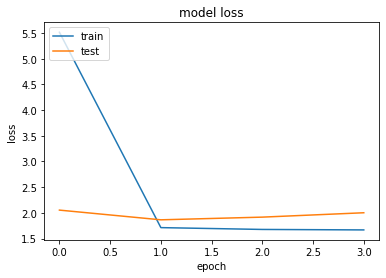

In [ ]:
time_index = np.array(dt['Date'])
data = np.array(dt['PM2.5'])

SPLIT_RATIO = 0.8

# Dividing into train-test split

split_index = int(SPLIT_RATIO * data.shape[0])

# Train-Test Split
train_data = data[:split_index]
train_time = time_index[:split_index]
test_data = data[split_index:]
test_time = time_index[split_index:]

WINDOW_SIZE = 60
BATCH_SIZE = 32
SHUFFLE_BUFFER = 1000

## function to create the input features

def ts_data_generator(data, window_size, batch_size, shuffle_buffer):

   ts_data = tf.data.Dataset.from_tensor_slices(data)
   ts_data = ts_data.window(window_size + 1, shift=1, drop_remainder=True)
   ts_data = ts_data.flat_map(lambda window: window.batch(window_size + 1))
   ts_data = ts_data.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
   ts_data = ts_data.batch(batch_size).prefetch(1)
   return ts_data# Expanding data into tensors

tensor_train_data = tf.expand_dims(train_data, axis=-1)
tensor_test_data = tf.expand_dims(test_data, axis=-1)


## generate input and output features for training and testing set

tensor_train_dataset = ts_data_generator(tensor_train_data, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER)
tensor_test_dataset = ts_data_generator(tensor_test_data, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER)


model = tf.keras.models.Sequential([tf.keras.layers.Conv1D(filters=32, kernel_size=5,strides=1, padding="causal",activation="relu",
   input_shape=[None, 1]),
   tf.keras.layers.LSTM(64, return_sequences=True),
   tf.keras.layers.LSTM(64, return_sequences=True),
   tf.keras.layers.Dense(30, activation="relu"),
   tf.keras.layers.Dense(10, activation="relu"),
   tf.keras.layers.Dense(1)])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
model.summary()
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

history = model.fit(tensor_train_dataset, epochs=4, validation_data=tensor_test_dataset)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [3]:
import random
data = np.array(pm10)
def model_forecast(model, data, window_size):
   
   ds = tf.data.Dataset.from_tensor_slices(data)
   ds = ds.window(window_size, shift=1, drop_remainder=True)
   ds = ds.flat_map(lambda w: w.batch(window_size))
   ds = ds.batch(32).prefetch(1)
   forecast = model.predict(ds)
   return forecast


rnn_forecast = model_forecast(model, data[..., np.newaxis], WINDOW_SIZE)
rnn_forecast = rnn_forecast[split_index - WINDOW_SIZE:-1, -1, 0]

plt.plot(50)
plt.plot(rnn_forecast)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['test', 'predictions'], loc='upper left')
plt.show()

NameError: ignored

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_new_converter=True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
tf.lite.OpsSet.SELECT_TF_OPS]

tfmodel = converter.convert()
open ('pms-predictor.tflite', 'wb').write(tfmodel)

INFO:tensorflow:Assets written to: /tmp/tmp4qagdubm/assets


INFO:tensorflow:Assets written to: /tmp/tmp4qagdubm/assets


88944